In [1]:
%%capture
from dask_jobqueue import SLURMCluster
from dask.distributed import Client
import xarray as xr
import os
import gsw
import time
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d, PchipInterpolator

In [2]:
cluster = SLURMCluster(queue='mpi_short1', cores=24, memory='48GB', processes=2)
cluster

In [3]:
client = Client(cluster)
client

Client Scheduler: tcp://192.168.0.11:36503 Dashboard: http://192.168.0.11:8787/status,Cluster Workers: 2 Cores: 24 Memory: 48.00 GB


In [4]:
from dask import delayed, compute
from dask.diagnostics import ProgressBar
import dask.dataframe as dd

In [48]:
@delayed
def get_data(argo_file):
    argo_file = xr.open_dataset(argo_file)
    lats = argo_file.LATITUDE.data
    lons = argo_file.LONGITUDE.data
    lons = np.where(lons<0, lons+360,lons)
    date = argo_file.JULD.data[0]
    date = np.repeat(pd.to_datetime(date).date(), len(lons))
    temp = argo_file.TEMP[:,0].data
    nprof = argo_file.N_PROF.data
#     new_temp =[]
#     for row in temp:
#         new_temp.append(row)
    df = {'date':date,'lat':lats,'lon':lons,'nprof':nprof,'temp':temp}
    pairs = pd.DataFrame(df,columns=['date','lat','lon','nprof','temp'])
    return pairs

@delayed
def merge_data(list_df):
    return pd.concat(list_df)

Here we list the files to open. The function will find and store any profiler inside the ROI since 1999.

In [19]:
ARGO_DIR = '/data/datos/ARGO/data/'
argo_files = [os.path.join(ARGO_DIR,x) for x in os.listdir(ARGO_DIR) if x.endswith('_prof.nc')]
len(argo_files)

7202

Load data and return a pandas datframe of **'date','lat','lon','nprof','temp'**

## This section only needs to be run once!
---

In [54]:
data = merge_data([get_data(argof) for argof in argo_files])

In [55]:
data.compute().head()

,date,lat,lon,nprof,temp
0,1999-04-11,38.856,145.190,0,12.020
1,1999-04-11,40.624,154.200,1,8.212
0,1999-01-01,42.621,155.969,0,8.692
0,1999-04-10,38.087,149.431,0,12.452
1,1999-04-10,39.776,143.998,1,11.268


In [6]:
data = pd.DataFrame([],columns=['date','lat','lon','nprof','temp'])
for file in argo_files:
    data = data.append(get_data(file))

In [28]:
data.head()

,date,lat,lon,nprof,temp
0,1999-04-11,38.856,145.190,0,12.020
1,1999-04-11,40.624,154.200,1,8.212
2,1999-01-01,42.621,155.969,0,8.692
3,1999-04-10,38.087,149.431,0,12.452
4,1999-04-10,39.776,143.998,1,11.268


In [8]:
data.to_csv('latlontemp.txt', index=False)

---

Load previously computed data

In [3]:
data = pd.read_csv('latlontemp.txt',parse_dates=[0])
data.head()

,date,lat,lon,nprof,temp
0,1999-04-11,38.856,145.190,0,12.020
1,1999-04-11,40.624,154.200,1,8.212
2,1999-01-01,42.621,155.969,0,8.692
3,1999-04-10,38.087,149.431,0,12.452
4,1999-04-10,39.776,143.998,1,11.268


In [18]:
delta = data.iloc[-1]['date'] - pd.DateOffset(10,'D')
data.drop(data[data['date']>=delta].index)

,date,lat,lon,nprof,temp
0,1999-04-11,38.856000,145.190000,0,12.0200
1,1999-04-11,40.624000,154.200000,1,8.2120
2,1999-01-01,42.621000,155.969000,0,8.6920
3,1999-04-10,38.087000,149.431000,0,12.4520
4,1999-04-10,39.776000,143.998000,1,11.2680
5,1999-01-02,37.204000,155.729000,0,19.3160
6,1999-01-02,37.130000,137.863000,1,14.3070
7,1999-01-02,37.973000,136.047000,2,12.9740
8,1999-01-02,34.888000,163.333000,3,16.7400
9,1999-01-02,41.337000,146.750000,4,8.0560


In [32]:
ix = [i for i,s in enumerate(argo_files) if '{:%Y%m%d}'.format(delta) in s]
argo_files[ix[0]:]

['/data/datos/ARGO/data/20190203_prof.nc',
 '/data/datos/ARGO/data/20190204_prof.nc',
 '/data/datos/ARGO/data/20190205_prof.nc',
 '/data/datos/ARGO/data/20190206_prof.nc',
 '/data/datos/ARGO/data/20190207_prof.nc',
 '/data/datos/ARGO/data/20190208_prof.nc',
 '/data/datos/ARGO/data/20190209_prof.nc',
 '/data/datos/ARGO/data/20190210_prof.nc',
 '/data/datos/ARGO/data/20190211_prof.nc',
 '/data/datos/ARGO/data/20190212_prof.nc',
 '/data/datos/ARGO/data/20190213_prof.nc']

Fix time variable to have the right dtype

In [10]:
# data['date'] = pd.to_datetime(data['date'])

Helper function to slice data

In [11]:
def filter_data(data, min_lat, min_lon, max_lat, max_lon,time1, time2):
    max_lat = max_lat
    max_lon = max_lon+1
    filt = data[(data['date']>time1)&(data['date']<time2)]
    filt = filt[(filt['lat']>min_lat)&(filt['lat']<max_lat)]
    filt = filt[(filt['lon']>min_lon)&(filt['lon']<max_lon)]
    x_grid = np.arange(min_lon,max_lon,0.5)
    y_grid = np.arange(min_lat,max_lat,0.5)
    return filt, x_grid, y_grid

---

Here we slice our data to make some computations later

In [12]:
date1 = "1999-01-01"
date2 = '2019-02-13'
filt_data, x_grid, y_grid = filter_data(data,-20,250,10.5,300,np.datetime64(date1),np.datetime64(date2))
filt_data.head()

,date,lat,lon,nprof,temp
1314,2000-07-13,-13.006,252.005997,1,23.901
1342,2000-07-23,-13.048,251.841003,0,23.711
1380,2000-08-03,-13.387,251.442001,1,23.445
1421,2000-08-13,-13.714,250.760002,0,23.454
1458,2000-08-24,-13.921,250.117996,7,23.634


In [13]:
# x_grid = np.arange(260,280,1)
# y_grid = np.arange(-20,10,1)
H, xedges, yedges =np.histogram2d(filt_data['lon'], filt_data['lat'], bins=(x_grid, y_grid))
H = H.T
H.shape

(60, 101)

In [14]:
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
plt.style.use('seaborn-paper')

proj = ccrs.PlateCarree(central_longitude=180)
fig, ax = plt.subplots(subplot_kw=dict(projection=proj),figsize=(24,12))
ax.set_xticks(np.arange(0,360,5), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-90,90,2.5), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
X, Y = np.meshgrid(xedges, yedges)

hq_land = cfeature.NaturalEarthFeature(
                            category='physical',
                            name='land',
                            scale='50m',
                            facecolor=cfeature.COLORS['land'])
hq_border = cfeature.NaturalEarthFeature(
                            category='cultural',
                            name='admin_0_countries',
                            scale='50m',
                            facecolor=cfeature.COLORS['land'],
                            edgecolor='black')
#ax.add_feature(hq_land)
ax.add_feature(hq_border)
ax.set_extent([70, 110, -20, 10], crs=proj)

draw = ax.pcolormesh(X, Y, H,edgecolor='w',lw=0.004,transform=ccrs.PlateCarree(),cmap=plt.get_cmap('GnBu',10))
cbar = plt.colorbar(draw, ticks = np.arange(np.min(H),np.max(H),10))
cbar.ax.tick_params(labelsize=15) 
# for i in range(len(yedges)-1):
#     for j in range(len(xedges)-1):
#         text = ax.text(j, i, H[i, j],
#                        ha="center", va="center", color="w")
# ax.plot(lats[~np.isnan(lats)]-180,lons[~np.isnan(lons)],ls='-',lw=1)
ax.coastlines()
fig.savefig('hist_argo.png', dpi=400)

In [15]:
from scipy.stats.kde import gaussian_kde
x = filt_data['lon'].values
y = filt_data['lat'].values
k = gaussian_kde(np.vstack([x, y]))

In [16]:
xi, yi = np.mgrid[x.min():x.max():H.shape[1]*1j,y.min():y.max():H.shape[0]*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

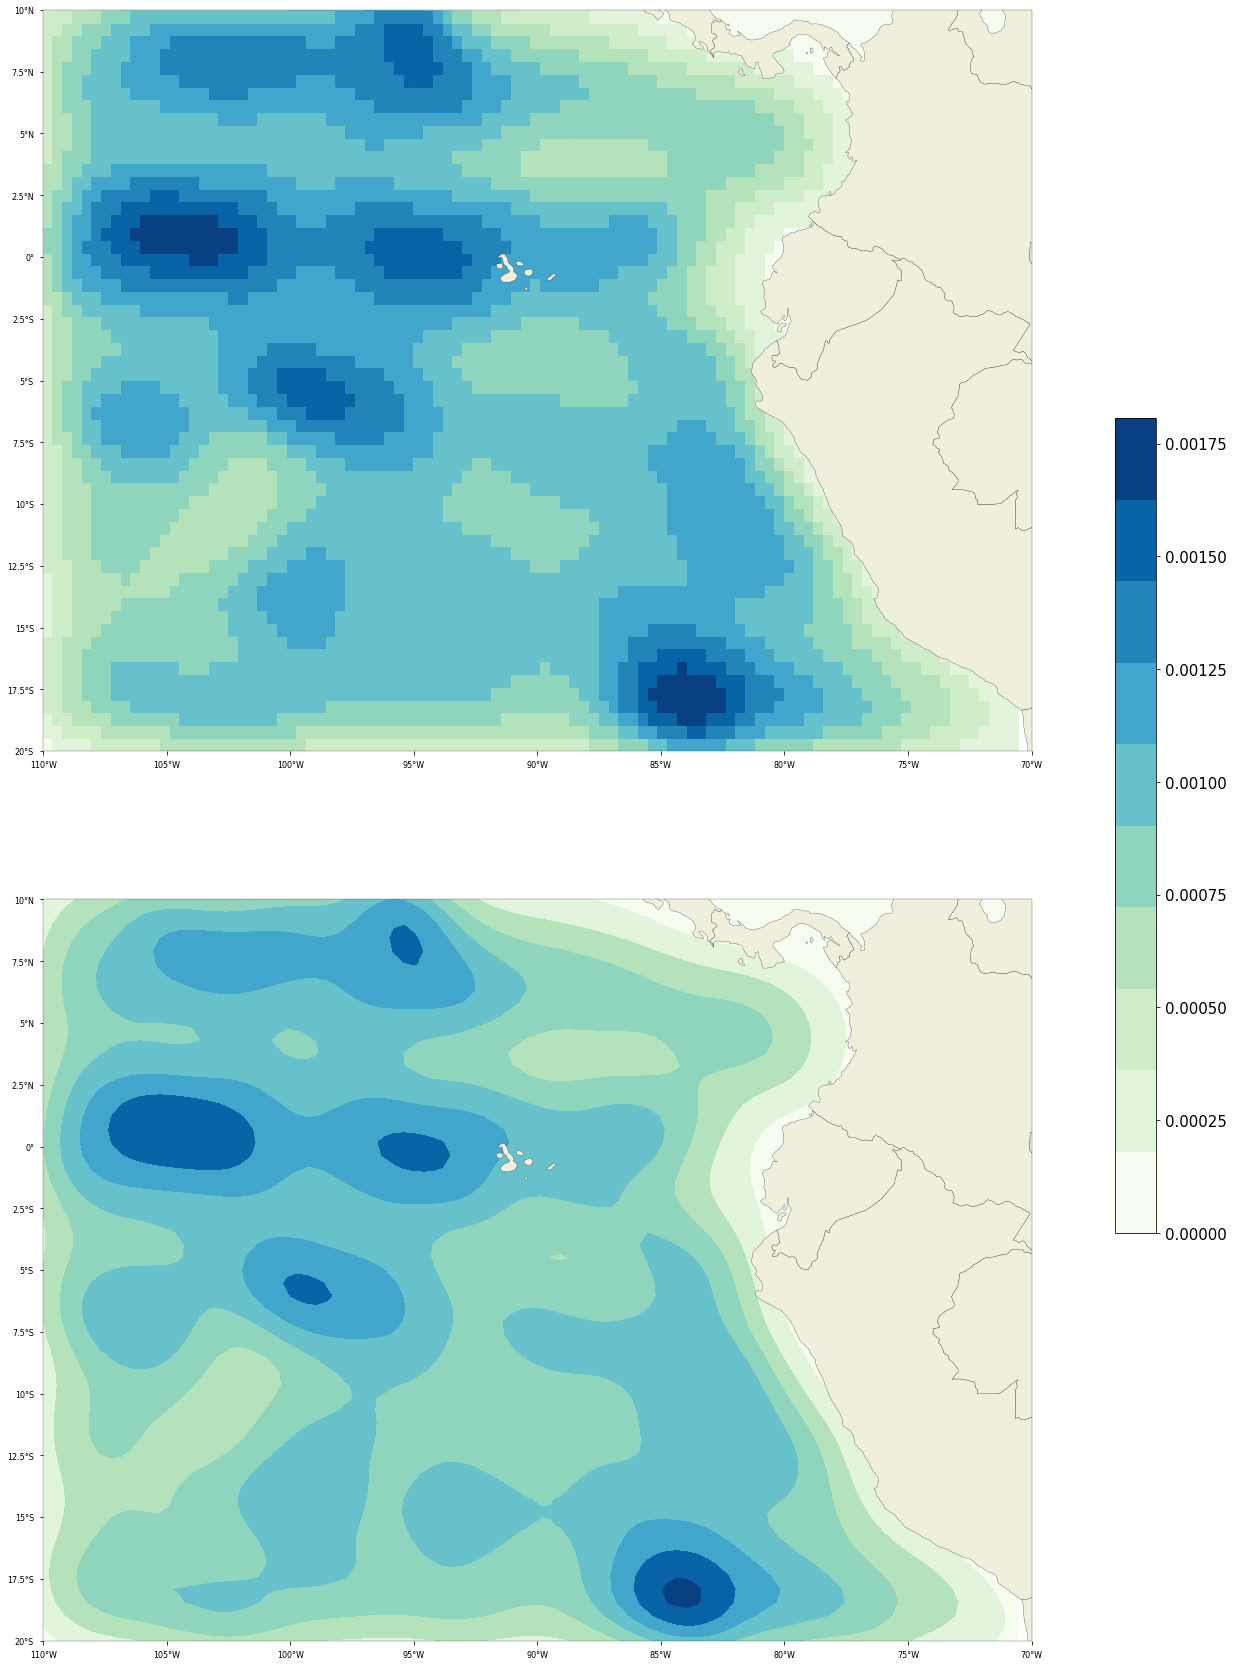

In [17]:
fig ,ax = plt.subplots(2,1,subplot_kw=dict(projection=proj),figsize=(30,30))
ax1 = ax[0] #= fig.add_subplot(211)
ax1.set_xticks(np.arange(0,360,5), crs=ccrs.PlateCarree())
ax1.set_yticks(np.arange(-90,90,2.5), crs=ccrs.PlateCarree())
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)
ax1.add_feature(hq_border)
ax1.set_extent([70, 110, -20, 10], crs=proj)

ax2 = ax[1] #fig.add_subplot(212)
ax2.set_xticks(np.arange(0,360,5), crs=ccrs.PlateCarree())
ax2.set_yticks(np.arange(-90,90,2.5), crs=ccrs.PlateCarree())
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
ax2.add_feature(hq_border)
ax2.set_extent([70, 110, -20, 10], crs=proj)

# alpha=0.5 will make the plots semitransparent
a = ax1.pcolormesh(xi, yi, zi.reshape(xi.shape),transform=ccrs.PlateCarree(),cmap=plt.get_cmap('GnBu',10))
ax2.contourf(xi, yi, zi.reshape(xi.shape),transform=ccrs.PlateCarree(),cmap=plt.get_cmap('GnBu',10))
cbar = fig.colorbar(a, orientation='vertical', ax=ax.flat, shrink=0.5)
cbar.ax.tick_params(labelsize=15)

fig.savefig('kde_argo.png', dpi=400)

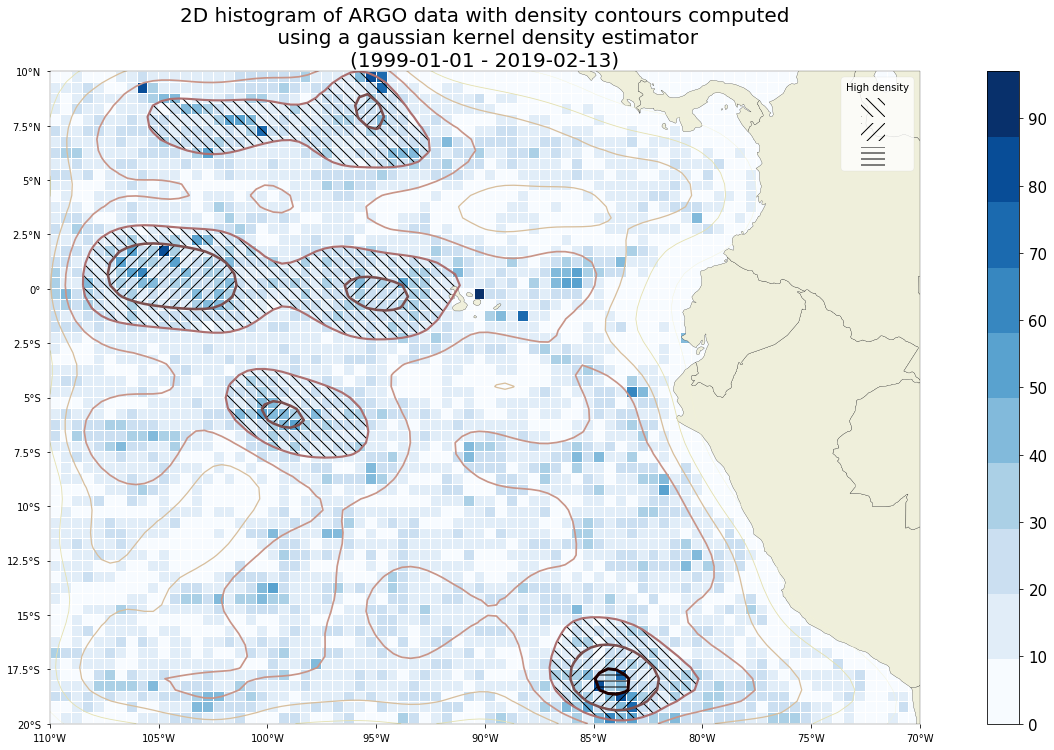

In [18]:
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
plt.style.use('seaborn-paper')

proj = ccrs.PlateCarree(central_longitude=180)
fig, ax = plt.subplots(subplot_kw=dict(projection=proj),figsize=(24,12))
ax.set_xticks(np.arange(0,360,5), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-90,90,2.5), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
X, Y = np.meshgrid(xedges, yedges)

hq_land = cfeature.NaturalEarthFeature(
                            category='physical',
                            name='land',
                            scale='50m',
                            facecolor=cfeature.COLORS['land'])
hq_border = cfeature.NaturalEarthFeature(
                            category='cultural',
                            name='admin_0_countries',
                            scale='50m',
                            facecolor=cfeature.COLORS['land'],
                            edgecolor='black')
#ax.add_feature(hq_land)
ax.add_feature(hq_border)
ax.set_extent([70, 110, -20, 10], crs=proj)
draw = ax.pcolormesh(X, Y, H,edgecolor='w',lw=0.004,transform=ccrs.PlateCarree(),cmap=plt.get_cmap('Blues',10))
ax.contour(xi, yi, zi.reshape(xi.shape),levels=8,transform=ccrs.PlateCarree(),cmap=plt.get_cmap('pink_r',8),linewidths=np.linspace(0,3,8))

cmap = plt.get_cmap('pink_r',8)
cmaplist = [cmap(i) for i in range(cmap.N)]
for j in range(len(cmaplist)):
    cmaplist[j] = (1.,1.,1.,0)
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

cs = ax.contourf(xi, yi, zi.reshape(xi.shape),transform=ccrs.PlateCarree(),cmap=cmap,hatches=[None,None,None,None,None,'\\\\', '//','--'])
artists, labels = cs.legend_elements()
ax.legend(artists[-3:],['','',''], handleheight=2, title='High density',fancybox=True,fontsize='large')

cbar = plt.colorbar(draw, ticks = np.arange(np.min(H),np.max(H),10))
cbar.ax.tick_params(labelsize=15) 

ax.tick_params(labelsize='medium')
ax.set_title('2D histogram of ARGO data with density contours computed\n using a gaussian kernel density estimator\n({} - {})'.format(date1,date2),size=20)
fig.savefig('hist+kde_argo.png', dpi=400)

---
## Computing GODAS temp climatology

In [91]:
GODAS_DIR = '/data/users/grivera/GODAS/temperature/'
godas_files = '{}*.nc'.format(GODAS_DIR)
godas_data = xr.open_mfdataset(godas_files, parallel=True)
temp = godas_data.pottmp.sel(time=slice('1980-01-01','2010-12-31'))
temp

<xarray.DataArray 'pottmp' (time: 372, level: 40, lat: 418, lon: 360)>
dask.array<shape=(372, 40, 418, 360), dtype=float32, chunksize=(12, 40, 418, 360)>
Coordinates:
  * level    (level) float32 5.0 15.0 25.0 35.0 ... 3016.0 3483.0 3972.0 4478.0
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * lat      (lat) float32 -74.5 -74.16667 -73.83334 ... 64.16566 64.499
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2010-12-01
Attributes:
    dataset:                  NCEP GODAS
    var_desc:                 potential temperature
    level_desc:               Multiple Levels
    statistic:                Monthly Mean
    parent_stat:              Individual Obs
    sub_center:               Environmental Modeling Center
    center:                   US National Weather Service - NCEP (WMC)
    long_name:                Potential temperature
    units:                    K
    level_indicator:          160
    gds_grid_type:            0
    par

In [20]:
temp_clim = temp.groupby('time.month').mean(dim='time')
#temp_clim = temp_clim.interp(level=grid)
temp_clim

<xarray.DataArray 'pottmp' (month: 12, level: 40, lat: 418, lon: 360)>
dask.array<shape=(12, 40, 418, 360), dtype=float32, chunksize=(1, 40, 418, 360)>
Coordinates:
  * level    (level) float32 5.0 15.0 25.0 35.0 ... 3016.0 3483.0 3972.0 4478.0
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * lat      (lat) float32 -74.5 -74.16667 -73.83334 ... 64.16566 64.499
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

---
#### Saving the monthly climatology
---

In [21]:
temp_clim.to_netcdf('godas_monthclim.nc')

In [19]:
temp_clim = xr.open_dataset('godas_monthclim.nc')
temp_clim = temp_clim.pottmp

---

### Converting monthly to daily climatology

In [82]:
def m2day_clim(clim,fyear='1979-01-01',nyears=46):
    clim = clim.sel(lat=slice(-20,10), lon=slice(250,290))
    new_range = pd.date_range(fyear,periods=nyears*12,freq='MS') + pd.DateOffset(14)
    daily_clim = xr.DataArray(np.tile(clim.load().data,[nyears,1,1,1]),
                              coords=[new_range,clim.level.data,clim.lat.data,clim.lon.data],
                              dims=['time','depth','lat','lon'])
    daily_clim = daily_clim.resample(time='1D').asfreq()
    return daily_clim.interpolate_na(dim='time', method='cubic')

In [83]:
daily = m2day_clim(temp_clim)
daily.name = 'pottmp'
daily

<xarray.DataArray 'pottmp' (time: 16772, depth: 40, lat: 90, lon: 40)>
array([[[[298.1083 , ..., 296.57825],
         ...,
         [299.96832, ...,       nan]],

        ...,

        [[      nan, ...,       nan],
         ...,
         [      nan, ...,       nan]]],


       ...,


       [[[297.31644, ..., 295.06363],
         ...,
         [300.37314, ...,       nan]],

        ...,

        [[      nan, ...,       nan],
         ...,
         [      nan, ...,       nan]]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-15 1979-01-16 ... 2024-12-15
  * depth    (depth) float32 5.0 15.0 25.0 35.0 ... 3016.0 3483.0 3972.0 4478.0
  * lat      (lat) float32 -19.83373 -19.5004 -19.16706 ... 9.499395 9.832726
  * lon      (lon) float32 250.5 251.5 252.5 253.5 ... 286.5 287.5 288.5 289.5

---
#### Saving the daily climatology
---

In [84]:
daily.to_netcdf('godas_dayclim.nc')

Loading daily climatology

In [20]:
daily = xr.open_dataset('godas_dayclim.nc')
daily = daily.pottmp - 273

---
#### Slicing the initial data to perform analysis on a high density area

In [21]:
reg1, reg1x, reg1y = filter_data(data,-2.5,253,2.5,260,date1,date2)

In [22]:
reg1 = reg1.sort_values('date')
reg1.head()

,date,lat,lon,nprof,temp
2451,2001-04-17,1.759,258.712,8,29.067
3441,2001-08-08,1.802,260.339,0,21.800
3565,2001-08-18,0.892,258.958,1,21.704
3667,2001-08-25,2.005,258.713,12,25.386
3707,2001-08-29,0.711,258.257,10,23.928


In [23]:
template = '{:%Y%m%d}_prof.nc'
def get_fn(date, temp):
    return os.path.join(ARGO_DIR,temp.format(date))
reg1['fname'] = reg1['date'].apply(get_fn,args={template})

In [24]:
reg1=reg1.reset_index(drop=True)
reg1.head()

,date,lat,lon,nprof,temp,fname
0,2001-04-17,1.759,258.712,8,29.067,/data/datos/ARGO/data/20010417_prof.nc
1,2001-08-08,1.802,260.339,0,21.800,/data/datos/ARGO/data/20010808_prof.nc
2,2001-08-18,0.892,258.958,1,21.704,/data/datos/ARGO/data/20010818_prof.nc
3,2001-08-25,2.005,258.713,12,25.386,/data/datos/ARGO/data/20010825_prof.nc
4,2001-08-29,0.711,258.257,10,23.928,/data/datos/ARGO/data/20010829_prof.nc


In [178]:
grid = np.arange(0,2001,2.)

def get_temp_anom(fname,prof,clim):
    data = xr.open_dataset(fname)
    temp = data.TEMP[prof].data
#     salt = data.PSAL[prof].data
#     salt = gsw.conversions.SA_from_SP(salt)
    depth = gsw.conversions.z_from_p(data.PRES[prof],data.LATITUDE[prof])
    mask = ~np.isnan(temp)
    mask[np.where(depth == 0)] = False
    if temp[mask].size ==1:
        return np.full_like(grid, np.nan
                            , dtype=np.double)
    try:
        func = PchipInterpolator(-depth[mask],temp[mask])#,kind='linear',fill_value=np.nan,bounds_error=False)
    except:
        print('Error on file {}'.format(fname))
        return np.full_like(grid, np.nan, dtype=np.double)
    new_grid = np.where(grid>-depth[mask][-1],np.nan,grid)
    new_grid[np.where(grid<-depth[mask][0])] = np.nan
    new_data = func(new_grid)
    
#     date = pd.to_datetime(data.JULD[prof].data).date()
#     lat = data.LATITUDE[prof].data
#     lon = data.LONGITUDE[prof].data
#     day = clim.sel(time=date)
#     day = day.interp(depth=grid)
    return new_data #- day.data

In [179]:
orig_data = grid
for r in reg1.itertuples():
    temp_arr = get_temp_anom(r.fname,r.nprof,daily)
    orig_data = np.vstack([orig_data,temp_arr])
orig_data = orig_data[1:]

In [235]:
argo_data = xr.Dataset({'temp':(['lat','lon','time','level'],np.array([[orig_data]]).astype(np.float))},
                        coords={'lon':[255],
                                'lat':[0],
                                'time':reg1.date.values,
                                'level':grid.astype(np.int64)})
# argo_data = argo_data.resample(time='1d').asfreq()
argo_data.lon.attrs=godas_data.lon.attrs
argo_data.lat.attrs=godas_data.lat.attrs
argo_data.level.attrs=godas_data.level.attrs
argo_data

<xarray.Dataset>
Dimensions:  (lat: 1, level: 1001, lon: 1, time: 3848)
Coordinates:
  * lon      (lon) int64 255
  * lat      (lat) int64 0
  * time     (time) datetime64[ns] 2001-04-17 2001-08-08 ... 2019-02-11
  * level    (level) int64 0 2 4 6 8 10 12 ... 1990 1992 1994 1996 1998 2000
Data variables:
    temp     (lat, lon, time, level) float64 nan nan nan 28.34 ... nan nan nan

In [236]:
argo_data.time

<xarray.DataArray 'time' (time: 3848)>
array(['2001-04-17T00:00:00.000000000', '2001-08-08T00:00:00.000000000',
       '2001-08-18T00:00:00.000000000', ..., '2019-02-05T00:00:00.000000000',
       '2019-02-09T00:00:00.000000000', '2019-02-11T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2001-04-17 2001-08-08 ... 2019-02-11

In [237]:
argo_data.to_netcdf('argo_data_uneven.nc')

In [128]:
# (orig_data - daily.sel(time=orig_data.time.data).interp_like(orig_data))
daily

<xarray.DataArray 'pottmp' (time: 16772, depth: 40, lat: 90, lon: 40)>
array([[[[25.108307, ..., 23.578247],
         ...,
         [26.968323, ...,       nan]],

        ...,

        [[      nan, ...,       nan],
         ...,
         [      nan, ...,       nan]]],


       ...,


       [[[24.316437, ..., 22.06363 ],
         ...,
         [27.373138, ...,       nan]],

        ...,

        [[      nan, ...,       nan],
         ...,
         [      nan, ...,       nan]]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-15 1979-01-16 ... 2024-12-15
  * depth    (depth) float32 5.0 15.0 25.0 35.0 ... 3016.0 3483.0 3972.0 4478.0
  * lat      (lat) float32 -19.83373 -19.5004 -19.16706 ... 9.499395 9.832726
  * lon      (lon) float32 250.5 251.5 252.5 253.5 ... 286.5 287.5 288.5 289.5

In [136]:
new_data = grid
region_mean = daily.mean(dim=['lat','lon'])
for r in reg1.itertuples():
    temp_arr = get_temp_anom(r.fname,r.nprof,region_mean)
    new_data = np.vstack([new_data,temp_arr])
new_data = new_data[1:]

2001-04-17
2001-08-08
2001-08-18
2001-08-25
2001-08-29
2001-09-07
2001-09-18
2001-09-28
2001-10-08
2003-02-05
2003-02-05
2003-02-05
2003-02-16
2003-02-16
2003-02-26
2003-02-27
2003-03-08
2003-03-09
2003-03-09
2003-03-19
2003-03-20
2003-03-30
2003-03-30
2003-04-09
2003-04-10
2003-04-10
2003-04-20
2003-04-21
2003-04-30
2003-05-01
2003-05-01
2003-05-11
2003-05-11
2003-05-12
2003-05-21
2003-05-21
2003-05-22
2003-05-22
2003-05-31
2003-06-01
2003-06-02
2003-06-11
2003-06-12
2003-06-21
2003-07-02
2003-07-12
2003-07-23
2004-06-07
2004-06-29
2004-07-09
2004-07-10
2004-07-19
2004-07-21
2004-07-30
2004-07-31
2004-08-10
2004-08-11
2004-08-20
2004-08-22
2004-08-31
2004-09-02
2004-09-11
2004-09-12
2004-09-21
2004-10-02
2004-10-13
2004-10-23
2004-11-03
2004-11-13
2004-11-24
2004-11-27
2004-12-05
2004-12-15
2005-01-05
2005-01-16
2005-06-08
2005-06-19
2005-06-30
2005-07-08
2005-07-11
2005-07-21
2005-08-01
2005-08-11
2005-08-22
2005-09-02
2005-09-12
2005-09-23
2005-10-04
2005-10-14
2005-10-25
2005-11-04

In [242]:
region_mean.interp_like(argo_data).to_netcdf('godas_clim_uneven.nc')

In [241]:
region_mean.sel(time=slice('2001-04-17','2019-02-11')).to_netcdf('godas_clim_daily.nc')

In [137]:
new_data = xr.DataArray(new_data,
                        coords=[reg1.date.values,grid],
                        dims=['time','depth'])
new_data

<xarray.DataArray (time: 3848, depth: 1001)>
array([[     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       ...,
       [     nan,      nan,      nan, ..., 0.531882,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan]])
Coordinates:
  * time     (time) datetime64[ns] 2001-04-17 2001-08-08 ... 2019-02-11
  * depth    (depth) float64 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03

In [155]:
# np.where((new_data>10),np.nan,new_data)
new_data.sel(depth=slice(0,300)).where(new_data<15).min()

<xarray.DataArray ()>
array(-6.999916)

In [104]:
godas_temp = godas_data.pottmp.sel(lat=slice(-2.5,2.5),lon=slice(253,260), time=slice('2001-04-17','2019-02-11')).mean(dim=['lat','lon'])
godas_anom = godas_temp.groupby('time.month') - temp_clim.sel(lat=slice(-2.5,2.5),lon=slice(253,260)).mean(dim=['lat','lon'])
godas_anom = godas_anom.drop('month')

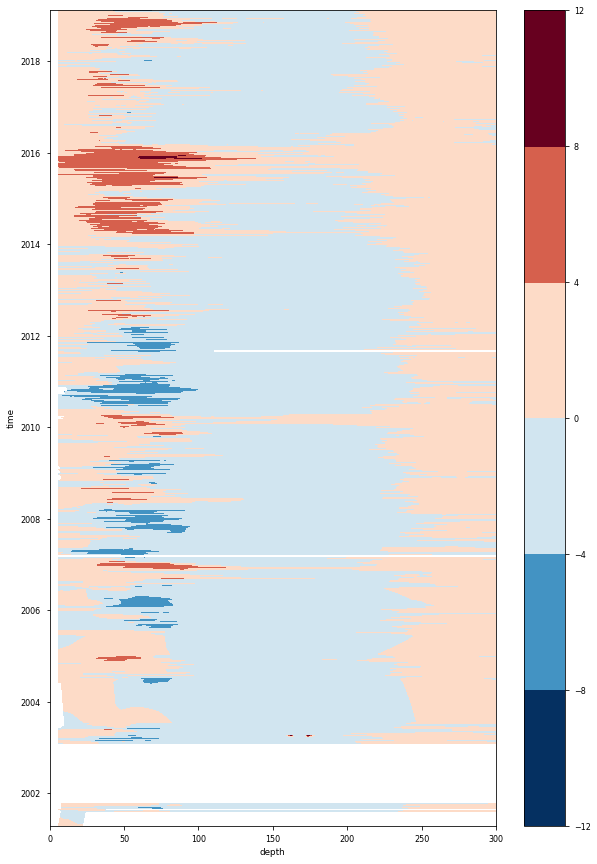

In [152]:
fig, ax = plt.subplots(figsize=(10,15))
new_data.where(new_data<15).sel(depth=slice(0,300)).plot.contourf(ax=ax)

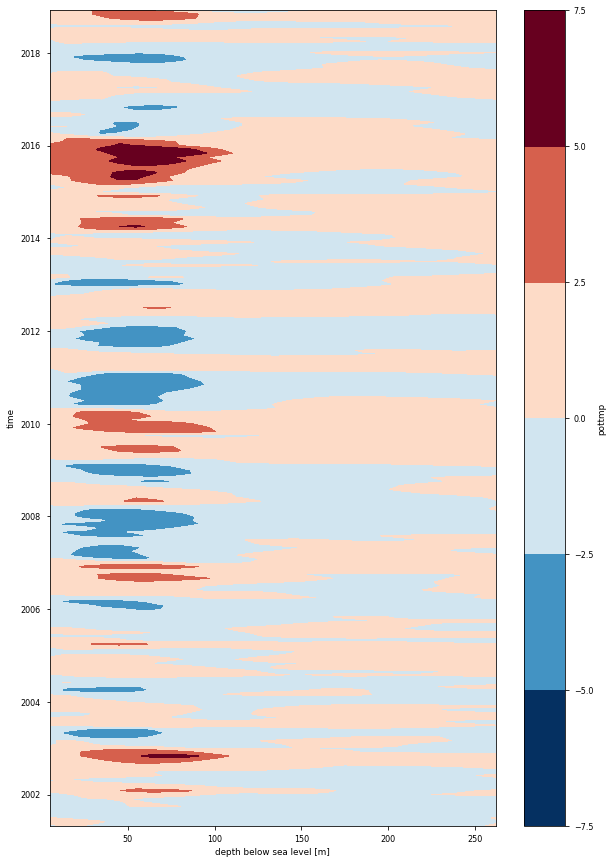

In [181]:
fig, ax = plt.subplots(figsize=(10,15))
(godas_anom).sel(level=slice(0,300)).plot.contourf(ax=ax)

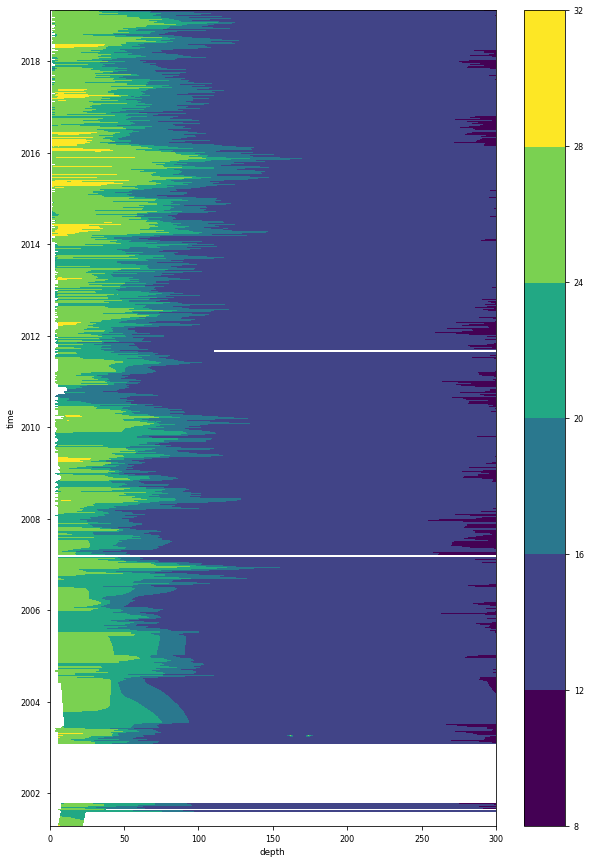

In [161]:
fig, ax = plt.subplots(figsize=(10,15))
(orig_data.where(orig_data<30)).sel(depth=slice(0,300)).plot.contourf(ax=ax)

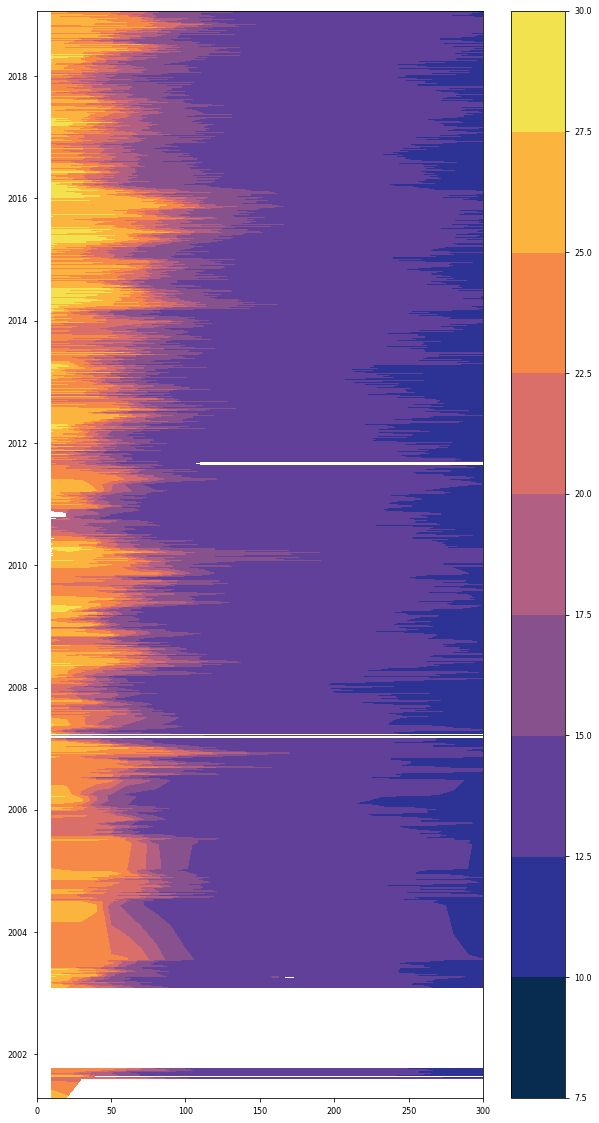

In [117]:
depth = 31
import cmocean as cmo
fig, ax = plt.subplots(figsize=(10,20))
# dra = ax.pcolormesh(new_df.columns.astype(np.int), new_df.index, new_df.values, cmap=cmo.cm.thermal)
dra = ax.contourf(new_df.columns.astype(np.int)[:depth], new_df.index, new_df.values[:,:depth],cmap=cmo.cm.thermal)
plt.colorbar(dra)

In [83]:
np.array([[new_data.data]]).shape

(1, 1, 6510, 1001)

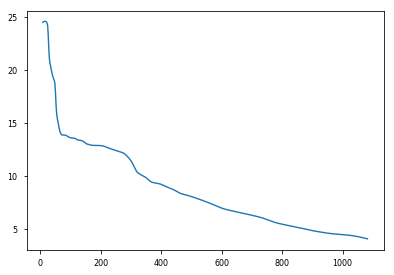

In [52]:
plt.plot(grid,new_data[6])

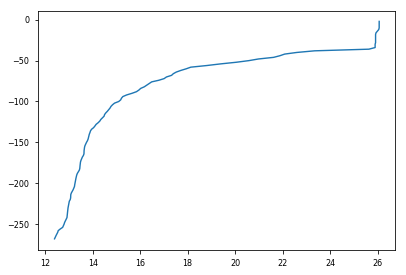

In [111]:
def reject_outliers(data, m = 4.6): 
    d = np.abs(data - np.median(data)) 
    mdev = np.median(d) 
    s = d/mdev if mdev else 0. 
    return data[s<m], s<m

a=2664
plt.plot(get_temp(reg1.loc[a]['fname'], reg1.loc[a]['nprof']), -grid)

In [419]:
new_df = pd.DataFrame([],index=reg1['date'],columns=grid)
for ind in reg1.index:
    new_df.iloc[ind] = get_temp(reg1.iloc[ind]['fname'],reg1.iloc[ind]['nprof'])
new_df.head()

,0,10,20,30,40,50,60,70,80,90,...,1910,1920,1930,1940,1950,1960,1970,1980,1990,2000
date,,,,,,,,,,,,,,,,,,,,,
2001-04-17,NaN,27.127,25.422,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-08-08,NaN,21.89,21.8888,21.7455,21.6381,21.5433,21.4124,21.1678,18.5567,17.0159,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-08-18,NaN,21.7451,21.6147,20.9932,19.9507,18.4866,17.9592,16.9883,15.8134,14.5985,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-08-25,NaN,25.536,25.5333,25.5175,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-08-29,NaN,24.0809,24.0172,22.1733,19.2943,18.0446,16.7677,14.8995,14.1919,14.0207,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [426]:
new_df.to_csv('temp_prof_ts.txt')

In [65]:
new_df = pd.read_csv('temp_prof_ts.txt',index_col='date',parse_dates=True,dtype=np.float64)
new_df.iloc[:10]

,0,10,20,30,40,50,60,70,80,90,...,1910,1920,1930,1940,1950,1960,1970,1980,1990,2000
date,,,,,,,,,,,,,,,,,,,,,
2001-04-17,NaN,27.127022,25.421976,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-08-08,NaN,21.890046,21.888753,21.745540,21.638072,21.543291,21.412397,21.167777,18.556698,17.015917,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-08-18,NaN,21.745122,21.614705,20.993216,19.950678,18.486599,17.959175,16.988273,15.813401,14.598521,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-08-25,NaN,25.535999,25.533338,25.517535,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-08-29,NaN,24.080875,24.017159,22.173261,19.294334,18.044574,16.767669,14.899452,14.191911,14.020717,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-09-07,NaN,20.442732,20.026641,19.031087,17.744247,17.436710,15.500189,14.784189,14.473221,14.120772,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-09-18,NaN,24.546967,24.529671,21.027959,19.515666,17.876996,14.823358,13.900922,13.852586,13.735617,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-09-28,NaN,24.504905,24.520983,24.455431,22.791860,21.174907,19.558038,18.692833,18.289651,17.413654,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-10-08,NaN,23.962473,23.993112,23.952204,23.763781,23.189997,22.537709,20.319704,17.055630,16.566759,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [66]:
new_df[new_df > 35] = np.nan

In [69]:
new_df = new_df.groupby('date').mean()

In [53]:
np.nanmax(new_df.values)

29.781822675308156

In [108]:
new_df.columns.shape

(201,)

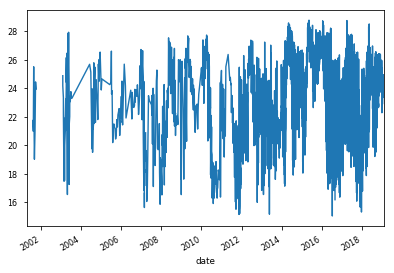

In [428]:
new_df[30].plot()